# Demo AG para optimizar predictores (con DEAP)

Se presenta un esquema básico para implementar este caso de uso de los Algoritmos Genéticos. La librería se denomina DEAP (*Distributed Evolutionary Algorithms in Python*).

Documentación y demás en: https://deap.readthedocs.io/en/master/

## Instalaciones y Dependencias Necesarias

In [1]:
pip install deap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 3.3 MB/s eta 0:00:00


In [2]:
import numpy as np
import random

import matplotlib.pyplot as plt
from sklearn import linear_model, datasets
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler

# Importaciones para AG
from deap import algorithms #incluye implementaciones completas de algoritmos genéticos, eaSimple por ejemplo. Se muestra un ejemplo en dónde hacemos a mano algo equivalente.
from deap import base #incluye las clases base de deap. En concreto dos son importantes en nuestro ejemplo, base.Fitness y base.Toolbox.
from deap import creator #permite crear clases nuevas.
from deap import tools #herramientas para implementar los algoritmos genéticos: operadores genéticos (selección, cruce y mutación), hallofFame, estadística, registro de evolución, etc.

## Dataset a utilizar

Una vez más... el conocido sobre calidad del aire.

In [3]:
# Descarga directo del Drive, no hace falta arrastrar
!wget -c --no-check-certificate "https://drive.google.com/uc?export=download&id=1VjETEiUgN5TyfAWbpZwTy7VNHkxwWSMV&confirm=t" -O dataset_ADL_clasificacion.zip

--2023-12-07 13:50:17--  https://drive.google.com/uc?export=download&id=1VjETEiUgN5TyfAWbpZwTy7VNHkxwWSMV&confirm=t
Resolving drive.google.com (drive.google.com)... 173.194.217.100, 173.194.217.101, 173.194.217.113, ...
Connecting to drive.google.com (drive.google.com)|173.194.217.100|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-04-9c-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/nrg1720doiu0q04v0kaqqotqu50906e1/1701957000000/12225850433951268217/*/1VjETEiUgN5TyfAWbpZwTy7VNHkxwWSMV?e=download&uuid=b83b9e0f-19b5-4980-9e23-1f135946dab8 [following]
--2023-12-07 13:50:18--  https://doc-04-9c-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/nrg1720doiu0q04v0kaqqotqu50906e1/1701957000000/12225850433951268217/*/1VjETEiUgN5TyfAWbpZwTy7VNHkxwWSMV?e=download&uuid=b83b9e0f-19b5-4980-9e23-1f135946dab8
Resolving doc-04-9c-docs.googleusercontent.com (doc-04-9c-docs.googleusercontent.com)... 142.250

In [4]:
!unzip -qq dataset_ADL_clasificacion.zip

In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split

dataset = pd.read_csv("dataset_ADL_clasificacion.csv")

In [6]:
y = dataset['Situacion'].to_numpy()
X = dataset.drop('Situacion', axis=1).to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=1)

## Modelo a utilizar

In [7]:
# Instanciamos el modelo a utilizar, puede ser cualquier clasificador
# Esta capacidad de decidir a bajo nivel cada etapa... es la que nos permite afinar para el lado que buscamos, investigar, etc.
# Pero cuesta más, hay que conocer de qué manera puede influir el modelo, etc etc.

# Va ejemplo como para que puedan cambiarse "bloques" sin romper lo demás

model = RandomForestClassifier(
                                n_estimators = 25,
                                random_state = 1234,
                                bootstrap    = False
                                )

## Funciones para obtener el Fitness

In [9]:
# Seteamos verbose en false, con True muestra mensajes de log en cada llamada
verbose = False

def calculate_fitness(model, x, y):
    cv_set = np.repeat(-1.0, x.shape[0])
    skf = StratifiedKFold(n_splits=5)
    for train_index, test_index in skf.split(x, y):
        x_train, x_test = x[train_index], x[test_index]
        y_train, y_test = y[train_index], y[test_index]
        if x_train.shape[0] != y_train.shape[0]:
            raise Exception()
        model.fit(x_train, y_train)
        predicted_y = model.predict(x_test)
        cv_set[test_index] = predicted_y
    return accuracy_score(y, cv_set)

def evaluate(individual):
    np_ind = np.asarray(individual)
    if np.sum(np_ind) == 0:
        fitness = 0.0
    else:
        feature_idx = np.where(np_ind == 1)[0]
        fitness = calculate_fitness(
            model, X[:, feature_idx], y
        )
        if verbose:
            print("Individuo: {}  Fitness Score: {} ".format(individual, fitness))

    return (fitness,)

## Instancias de la Librería

In [10]:
creator.create("FeatureSelect", base.Fitness, weights=(1.0,))  # Los pesos definen si se Maximiza (1) o Minimiza (-1) en la Optimización
creator.create("Individual", list, fitness=creator.FeatureSelect)

# Registro de las funciones necesarias
toolbox = base.Toolbox()

In [11]:
n_features = X.shape[1] # Cantidad de características a evaluar. En este caso, las 6 columnas de las variables de entrada.

# Funciones de inicilización del individuo y de la población
toolbox.register("attr_bool", random.randint, 0, 1)                             # Tipo de variable que nos interesa, booleanos ya que queremos determinar si queda o no cierto descriptor del problema
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, n_features)     # Se crea un individuo "modelo"
toolbox.register("population", tools.initRepeat, list, toolbox.individual)                              # Se crea la población con individuos como el "modelo"

# Definiciones respecto a cómo se muta, cómo se eligen, como se reproducen los individuos
toolbox.register("mate", tools.cxTwoPoint)                      # Crossover
toolbox.register("mutate", tools.mutFlipBit, indpb=0.1)         # Mutación
toolbox.register("select", tools.selTournament, tournsize=3)    # Seleción

# Función de evaluación
toolbox.register("evaluate", evaluate) # Evaluación, se apunta a nuestra función

## Hiperparámetros

In [12]:
N_POP = 20  # Tamaño de la población
CXPB = 0.5  # Probabilidad de crossover
MUTPB = 0.1 # Probabilidad de mutación
NGEN = 15   # Cantidad de generaciones

print(
    "Tamaño población: {}\nProbabilidad de crossover: {}\nProbabilida de mutación: {}\nGeneraciones totales: {}".format(
        N_POP, CXPB, MUTPB, NGEN
    )
)

Tamaño población: 20
Probabilidad de crossover: 0.5
Probabilida de mutación: 0.1
Generaciones totales: 15


## Función Auxiliar para estadísticas

In [13]:
# Función para generar salidas con estadisticas de cada generacion
# Abajo se muestra como conseguir algo similar, simplemente registrando las métricas
# en la clase dedicada a las estadísticas.

def build_stats(gen, pop, fits):
    record = {}
    length = len(pop)
    mean = sum(fits) / length
    sum2 = sum(x * x for x in fits)
    std = abs(sum2 / length - mean ** 2) ** 0.5

    record['gen'] = gen + 1
    record['min'] = min(fits)
    record['max'] = max(fits)
    record['avg'] = mean
    record['std'] = std

    if verbose:
        print("  Min {}  Max {}  Avg {}  Std {}".format(min(fits), max(fits), mean, std))

    return record

## Control Manual de las iteraciones

In [14]:
# Todo lo de este bloque, lo podemos realizar con eaSimple por ejemplo. Importada desde deap.alorihtms
# Pero se deja asentada la flexibilidad de la utilización de la librería, permitiendo controlar
# cada aspecto en las iteraciones.


# Inicializamos a la poblacion
pop = toolbox.population(N_POP)

print("Evaluamos a los individuos inicializados.......")
fitnesses = list(map(toolbox.evaluate, pop))

# Asignamos a los inviduos el score del paso anterior
for ind, fit in zip(pop, fitnesses):
    ind.fitness.values = fit

fitness_in_generation = {} # Variable auxiliar para generar el reporte
stats_records = [] # Variable auxiliar para generar el reporte

print("-- GENERACIÓN 0 --")
stats_records.append(build_stats(-1, pop, fitnesses[0]))

for g in range(NGEN):
    print("-- GENERACIÓN {} --".format(g + 1))
    # Seleccionamos a la siguiente generacion de individuos
    offspring = toolbox.select(pop, len(pop))

    # Clonamos a los invidiuos seleccionados
    offspring = list(map(toolbox.clone, offspring))

    # Aplicamos crossover y mutacion a los inviduos seleccionados
    for child1, child2 in zip(offspring[::2], offspring[1::2]):
        if random.random() < CXPB:
            toolbox.mate(child1, child2)
            del child1.fitness.values
            del child2.fitness.values

    for mutant in offspring:
        if random.random() < MUTPB:
            toolbox.mutate(mutant)
            del mutant.fitness.values


    # Evaluamos a los individuos con una fitness invalida
    weak_ind = [ind for ind in offspring if not ind.fitness.valid]
    fitnesses = list(map(toolbox.evaluate, weak_ind))
    for ind, fit in zip(weak_ind, fitnesses):
        ind.fitness.values = fit

    if verbose:
        print("Individuos evaluados: {}".format(len(weak_ind)))

    # Reemplazamos a la poblacion completamente por los nuevos descendientes
    pop[:] = offspring

    # Mostramos las salidas de la estadisticas de la generacion actual
    fits = [ind.fitness.values[0] for ind in pop]

    stats_records.append(build_stats(g, pop, fits))

Evaluamos a los individuos inicializados.......
-- GENERACIÓN 0 --
-- GENERACIÓN 1 --
-- GENERACIÓN 2 --
-- GENERACIÓN 3 --
-- GENERACIÓN 4 --
-- GENERACIÓN 5 --
-- GENERACIÓN 6 --
-- GENERACIÓN 7 --
-- GENERACIÓN 8 --
-- GENERACIÓN 9 --
-- GENERACIÓN 10 --
-- GENERACIÓN 11 --
-- GENERACIÓN 12 --
-- GENERACIÓN 13 --
-- GENERACIÓN 14 --
-- GENERACIÓN 15 --


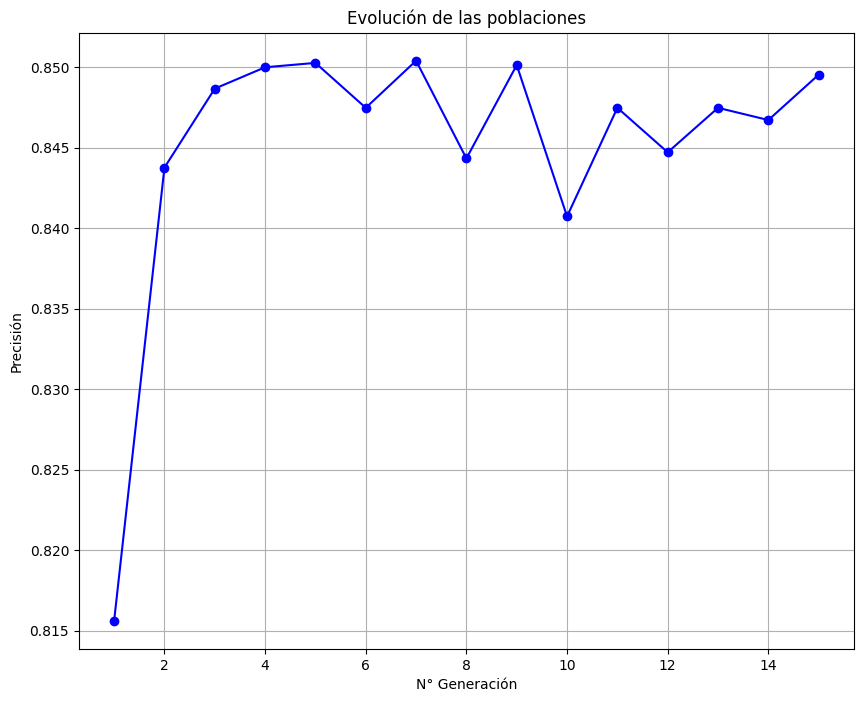

In [15]:
# Ploteamos el AVG por generacion
plt.figure(figsize=(10,8))
front = np.array([(c['gen'], c['avg']) for c in stats_records])
plt.plot(front[:,0][1:], front[:,1][1:], "-bo")
plt.axis("tight")
plt.grid(True)
plt.xlabel("N° Generación")
plt.ylabel("Precisión")
plt.title("Evolución de las poblaciones")   # avg era la métrica, así que da una noción del desempeño general de las poblaciones a lo largo del tiempo
plt.show()

In [16]:
best_solution = tools.selBest(pop, 1)[0]
print(
    "El mejor individuo es: \n{}, con un Accuracy de {}".format(best_solution, best_solution.fitness.values)
)

# En True se obtienen los predictores óptimos para el mejor individuo

El mejor individuo es: 
[0, 0, 1, 1, 1, 1], con un Accuracy de (0.8504065040650407,)


## Utilizando eaSimple

In [17]:
pop = toolbox.population(N_POP) # Población inicial
hof = tools.HallOfFame(5) # Espacio para guardar los mejores individuos

# Estadisticas a almacenar de las generaciones
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)
logbook = tools.Logbook() # Para almacenar todas las estadísticas calculadas por generación en un solo objeto.

# Evaluación sencilla del AG
best, logbook = algorithms.eaSimple(pop, toolbox, CXPB, MUTPB, NGEN, stats=stats, halloffame=hof, verbose=True)

gen	nevals	avg     	std      	min     	max     
0  	20    	0.742249	0.0740621	0.508401	0.847696
1  	11    	0.800298	0.0385306	0.680759	0.850407
2  	6     	0.835854	0.0193605	0.8     	0.850407
3  	15    	0.841355	0.0203415	0.775068	0.850407
4  	9     	0.850271	0.000590637	0.847696	0.850407
5  	10    	0.850407	1.11022e-16	0.850407	0.850407
6  	6     	0.850407	1.11022e-16	0.850407	0.850407
7  	12    	0.848943	0.00637888 	0.821138	0.850407
8  	5     	0.850407	1.11022e-16	0.850407	0.850407
9  	11    	0.849783	0.00271693 	0.83794 	0.850407
10 	13    	0.847209	0.0127503  	0.79187 	0.850407
11 	18    	0.850407	1.11022e-16	0.850407	0.850407
12 	13    	0.849539	0.0027975  	0.838482	0.850407
13 	11    	0.850407	1.11022e-16	0.850407	0.850407
14 	11    	0.850407	1.11022e-16	0.850407	0.850407
15 	9     	0.850136	0.00118127 	0.844986	0.850407


In [18]:
def plot_evolucion(logbook):
    gen = logbook.select("gen")
    fit_mins = np.array(logbook.select("min"))
    fit_maxs = np.array(logbook.select("max"))
    fit_avgs = np.array(logbook.select("avg"))

    fig, ax1 = plt.subplots()
    ax1.plot(gen, fit_mins, "b")
    ax1.plot(gen, fit_maxs, "r")
    ax1.plot(gen, fit_avgs, "--k")

    ax1.fill_between(gen, fit_mins, fit_maxs,
                     where=fit_maxs >= fit_mins,
                     facecolor="g", alpha=0.2)

    ax1.set_xlabel("Generaciones")
    ax1.set_ylabel("Fitness")
    ax1.legend(["Min", "Max", "Avg"])
    plt.grid(True)
    plt.show()

Mejor fitness:  (0.8504065040650407,)
Mejor individuo:  [0, 0, 1, 1, 1, 1]


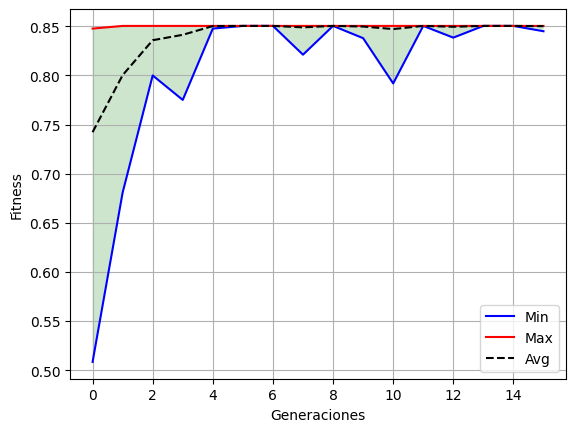

In [19]:
print("Mejor fitness: ", hof[0].fitness.values)
print("Mejor individuo: ", hof[0]) # En True se obtienen los predictores óptimos, la misma representación de siempre
plot_evolucion(logbook) # mostamos la evolución